# Processing Steps Delayed Mode
- author: J. Klymak
- deployment: dfo-bb046-20200717
- glider: dfo-bb046
- description: Calvert Island to shelf break, some of like doubled.  

## Copy data from card offload

In [1]:
!ls

bad_salinity.csv               process_delayed_20191209.ipynb
deployment.yml                 process_delayed_20191209.py
figs                           process_delayed_20200717.ipynb
process_delayed_20191209.html  process_delayed_20200717.py


## Set up the processing

This largely gets driven by `process_deployment.py`.  Note that some directories need to be made, the `cac` files need to be copied from t

In [2]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import seawater 
%matplotlib notebook
import matplotlib.units as munits
import pyglider
import pyglider.ncprocess as ncprocess

import matplotlib.dates as mdates

converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter

import scipy.signal as signal
import scipy.stats as stats
import pyglider.ncprocess as ncprocess



%load_ext autoreload
%autoreload 2


Bad key "axes.color_cycle" on line 19 in
/Users/jklymak/.matplotlib/stylelib/ggplotjmk.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution


In [18]:
deploy_name = 'dfo-bb046-20200717'
deploy_prefix = '/Users/jklymak/gliderdata/deployments/dfo-bb046/dfo-bb046-20200717/'
!mkdir figs
def get_timeseries(level='L0'):
    return xr.open_dataset(f'{deploy_prefix}/{level}-timeseries/{deploy_name}_{level}.nc')

def get_gridfile(level='L0'):
    return xr.open_dataset(f'{deploy_prefix}/{level}-gridfiles/{deploy_name}_grid.nc')

mkdir: figs: File exists


## Profile Check

Check that the profile computing algorithm worked well.

As can be seen in the plot below, the profiles are being properly associated with up and down casts.

1747149


<IPython.core.display.Javascript object>


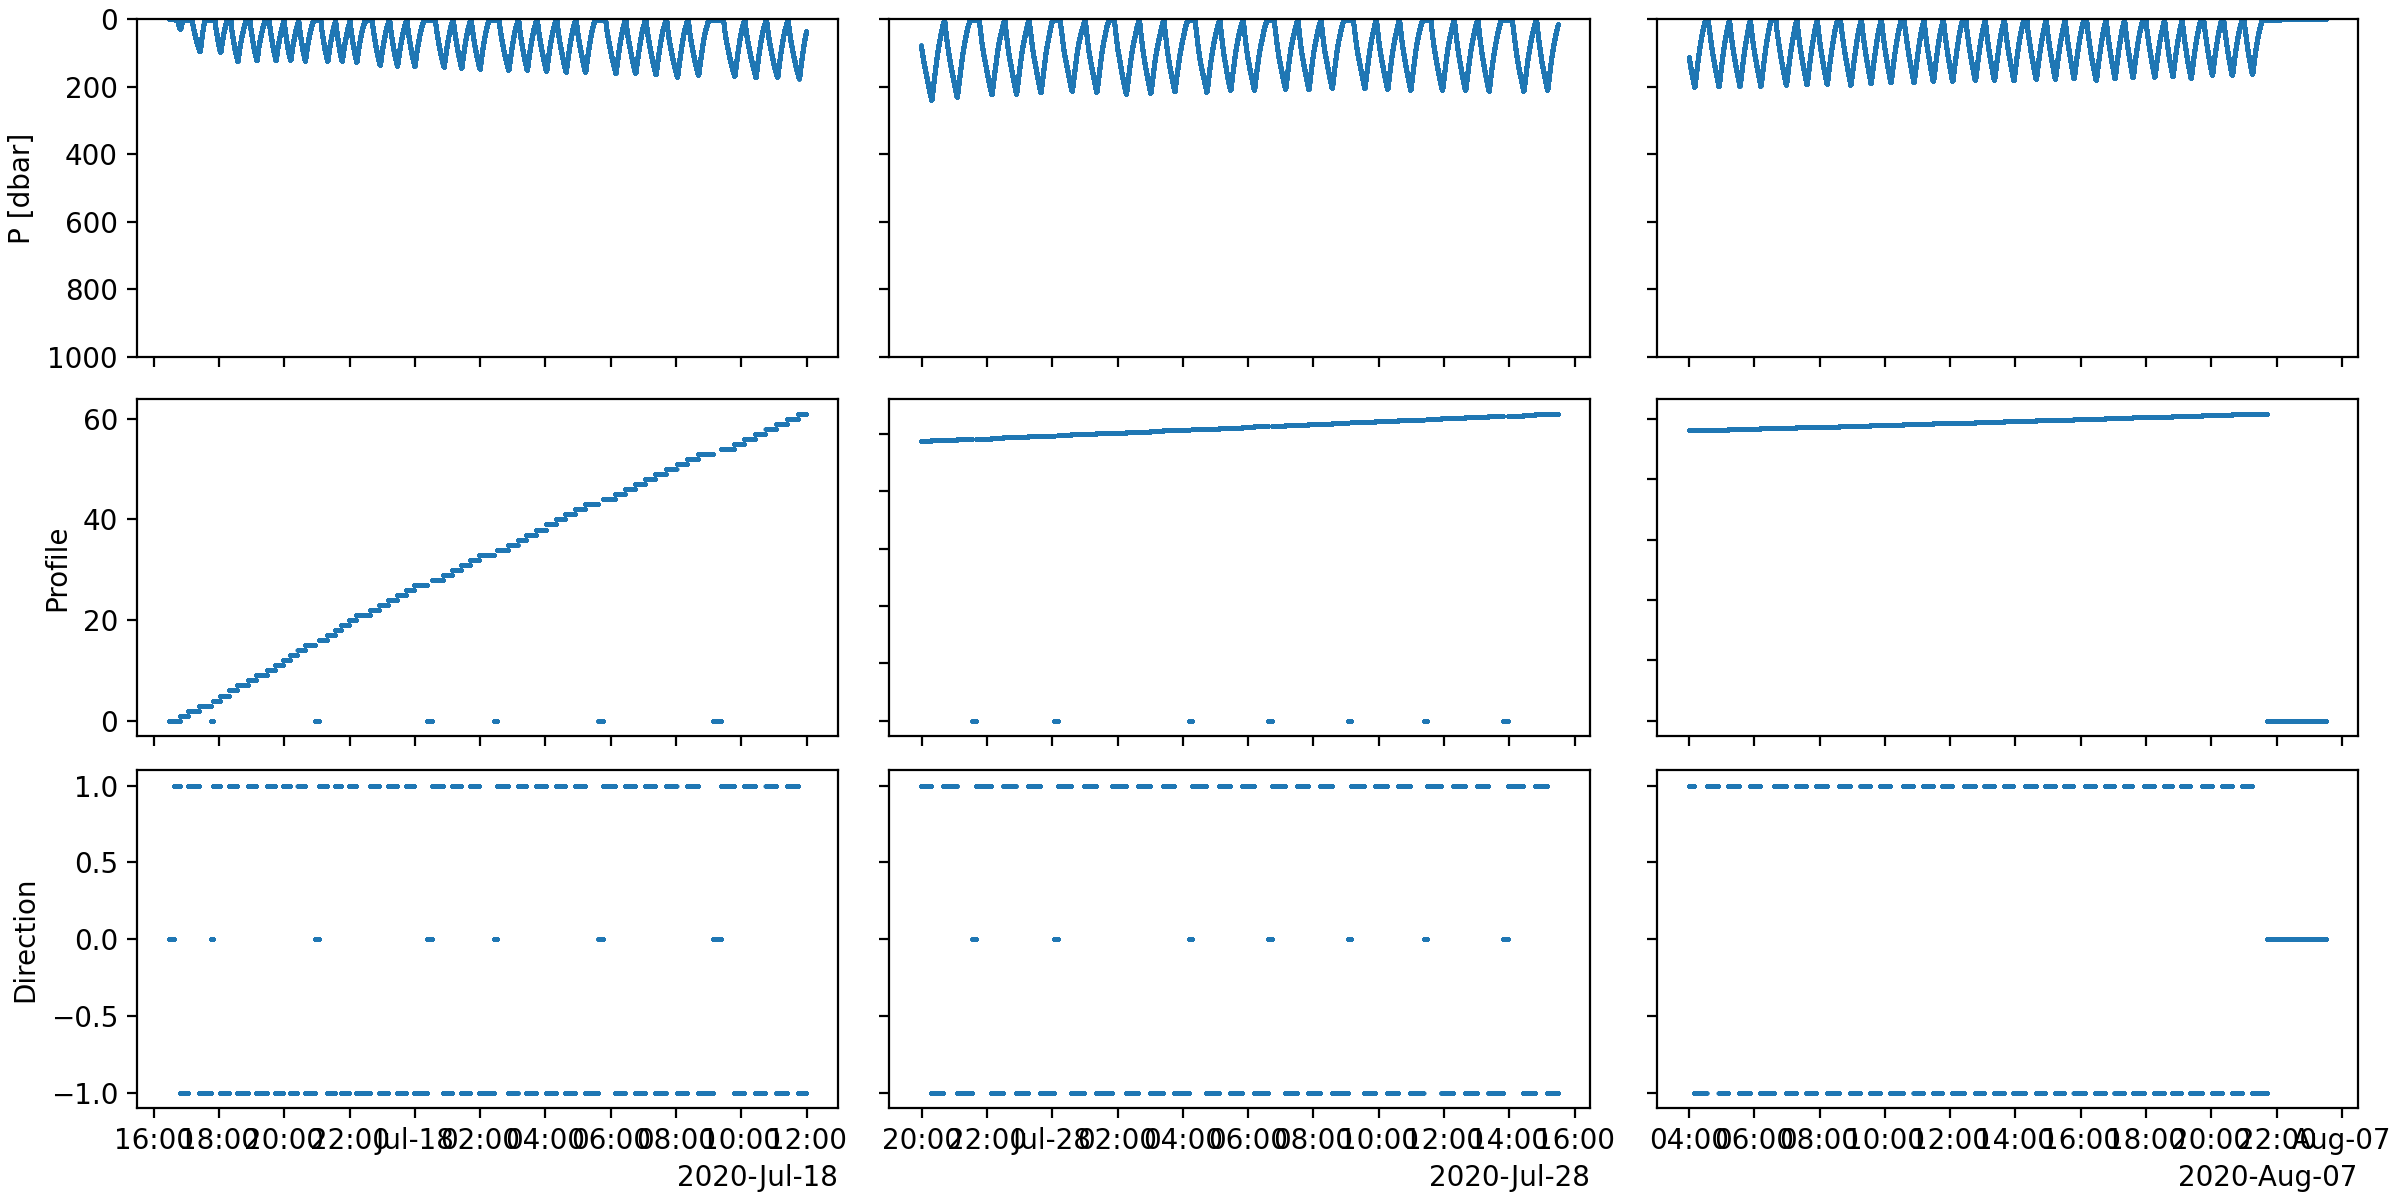

In [10]:
def plot_profiles(fname, plotname):

    with xr.open_dataset(fname) as ds0:
        N = len(ds0.time)
        print(N)
        todo = [slice(0, 70000), slice(int(N/2), int(N/2)+70000), slice(-70000, -1),]
        fig, axs = plt.subplots(nrows=3, ncols=3, constrained_layout=True, figsize=(12, 6))

        for nn, td in enumerate(todo):
            ds = ds0.isel(time=td)
            axs[0, nn].plot(ds.time, ds.pressure, '.', markersize=1)
            axs[0, nn].set_ylim([1000, 0])
            if nn==0:
                axs[0, nn].set_ylabel('P [dbar]')
            else:
                axs[0, nn].set_yticklabels('')
            axs[0, nn].set_xticklabels('')
   
            axs[1, nn].plot(ds.time, ds.profile_index, '.', markersize=1)
            if nn==0:
                axs[1, nn].set_ylabel('Profile')
            else:
                axs[1, nn].set_yticklabels('')
            axs[1, nn].set_xticklabels('')

            axs[2, nn].plot(ds.time, ds.profile_direction, '.', markersize=1)
            if nn==0:
                axs[2, nn].set_ylabel('Direction')
            else:
                axs[2, nn].set_yticklabels('')
            for ii in range(1, 3):
                axs[0, nn].get_shared_x_axes().join(axs[0, nn], axs[ii, nn])

            plt.show()
    fig.savefig(plotname)
            
plot_profiles(f'{deploy_prefix}/L0-timeseries/{deploy_name}_L0.nc', 'figs/ProfileCheck.png')


## Check for suspect salinity profiles

Biology often gets caught in the conductivity cell and leads to large blips in the salinity (and sometimes the temperature).  This simple check looks for profiles that are obviously contaminated by this to exclude from analysis below.  More stringent checks will be applied later

<IPython.core.display.Javascript object>


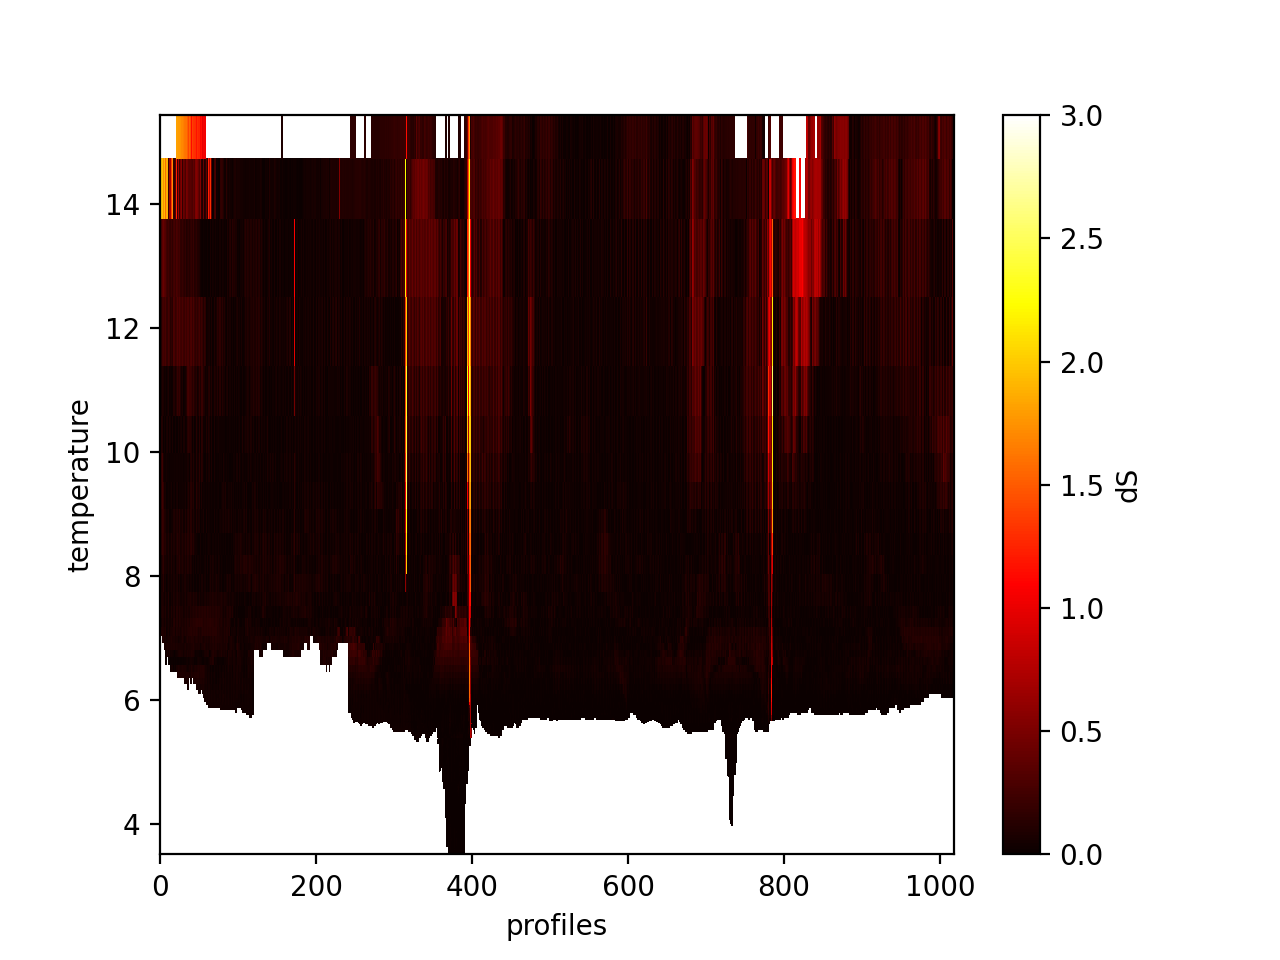

/Users/jklymak/anaconda3/envs/glider_analysis/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/jklymak/anaconda3/envs/glider_analysis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jklymak/anaconda3/envs/glider_analysis/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Bad: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  16. 315. 316. 395.
 396. 397. 398. 399. 781. 784. 785. 786.]


In [15]:

with get_gridfile() as ds:
    fig, ax = plt.subplots()
    Tmean = ds['temperature'].mean(dim='time')

Tmean = Tmean.sortby(Tmean, ascending=True).where(np.isfinite(Tmean), drop=True)

def get_salinity_grid(ts):
    ts = ts.where(np.isfinite(ts.salinity), drop=True)
    
    # bin the data:
    tbins = Tmean.values[::7]
    profile_bins = np.unique(ts['profile_index'])
    profile_bins = np.hstack([profile_bins, profile_bins[-1]+1])
    direction = profile_bins * 0
    for n, i in enumerate(profile_bins):
        ind = np.where(ts['profile_index'] == i)[0]
        direction[n] = np.median(ts.profile_direction[ind])

        
    salin, xx, yy, binn = stats.binned_statistic_2d(
                        ts['temperature'].values,
                        ts['profile_index'].values,
                        values=ts['salinity'].values, statistic='mean',
                        bins=[tbins, profile_bins])
    sal = xr.Dataset({'profiles': profile_bins[:-1], 'temperature': tbins[:-1]+np.diff(tbins)/2, 'salinity':(('temperature', 'profiles'), salin)})
    sal['dS'] = np.abs(sal.salinity - sal.salinity.mean(dim='profiles'))
    sal['dS'].plot(vmin=0, vmax=3, cmap='hot')
    sal['salinityClean'] = sal.salinity.where( sal.dS < 4 * sal.salinity[:, :1000].std(dim='profiles'))
    sal['NgoodSal'] = (sal.salinity / sal.salinity).sum(dim='temperature')

    sal['NgoodSalClean'] = (sal.salinityClean / sal.salinityClean).sum(dim='temperature')
    sal['profile_direction'] = direction

    sal['bad'] = (sal.NgoodSal - sal.NgoodSalClean) / sal.NgoodSal
    Bad = sal.bad + 0 * sal.salinityClean
    
    sal['salinityClean'] = sal.salinityClean.where(Bad<0.025) 
    
    return sal

with get_timeseries() as ts:
    # ts = ts.sel(time=slice(np.datetime64('2019-09-25'), np.datetime64('2019-09-27T03:00:00')))
    sal = get_salinity_grid(ts)
    
sal.to_netcdf('SalinityGrid.nc')
bad_profiles = sal.profiles.where(sal.bad > 0.05, drop=True)
print('Bad:', bad_profiles.values)


From the below plots, where salinity is plotted into temperature space, we see that salinities that are about 4 standard deviations from the mean are good candidates to flag:

<IPython.core.display.Javascript object>


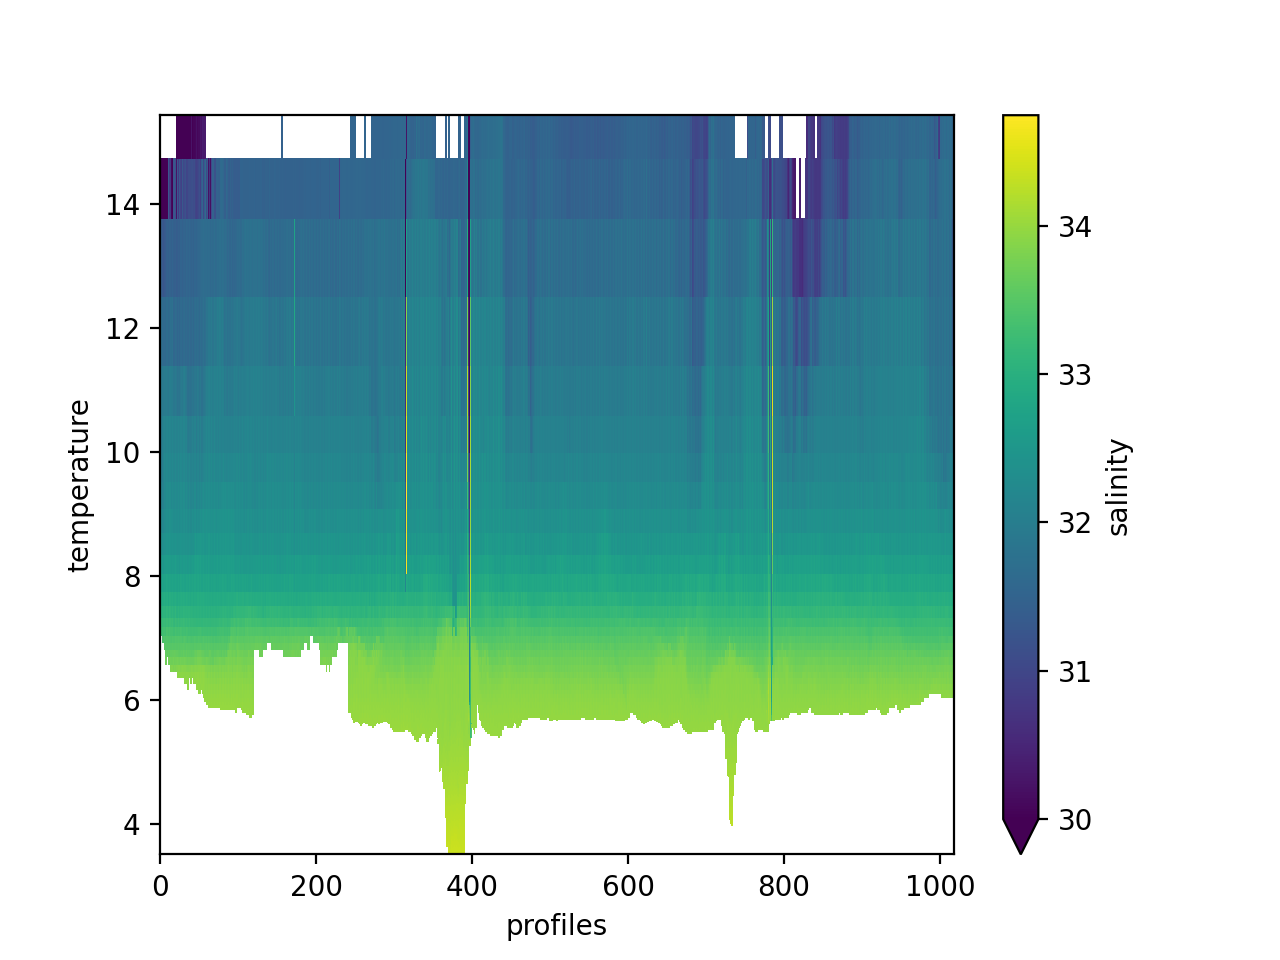

<IPython.core.display.Javascript object>


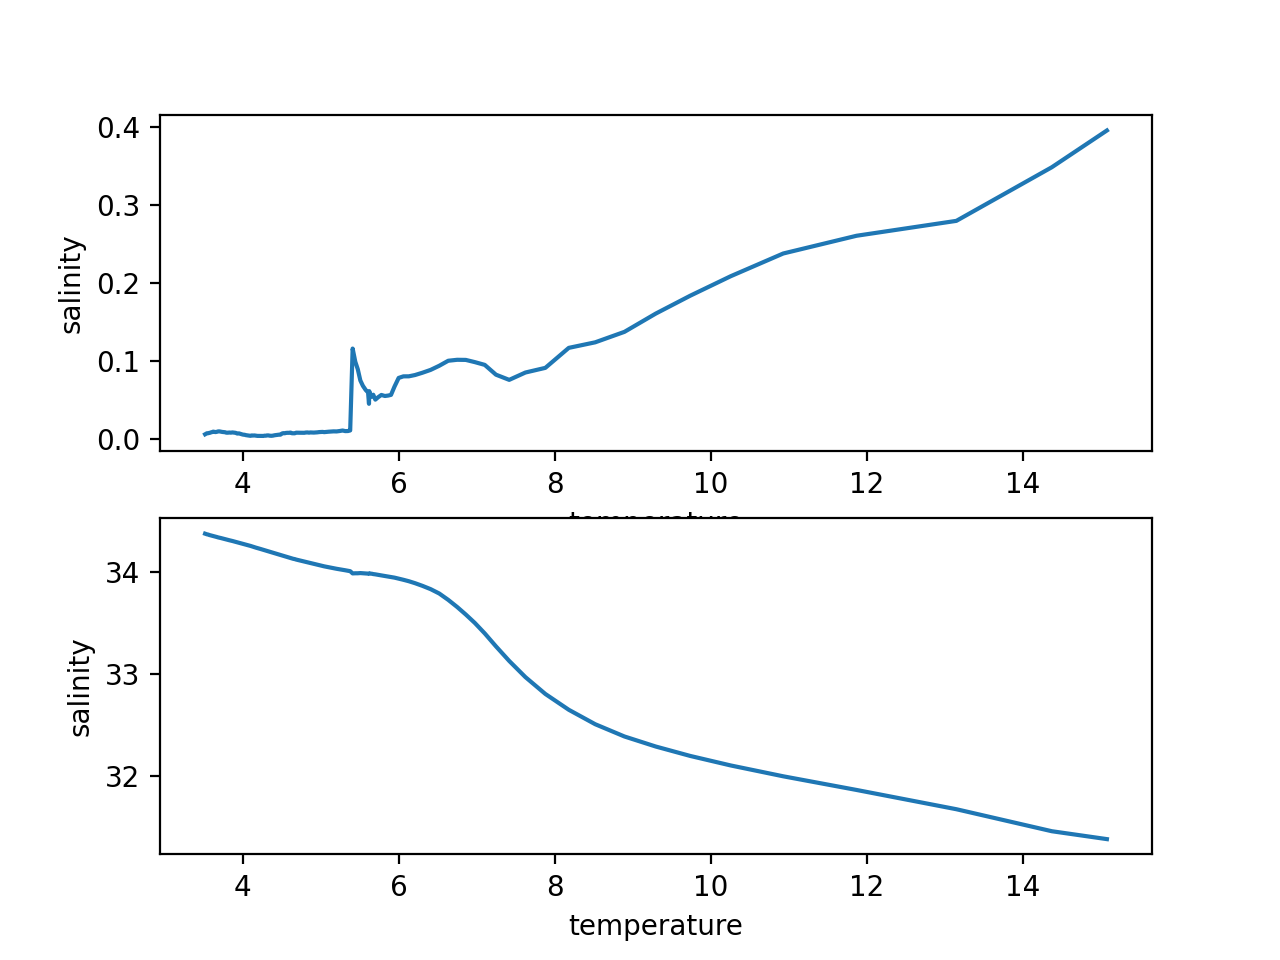

<IPython.core.display.Javascript object>


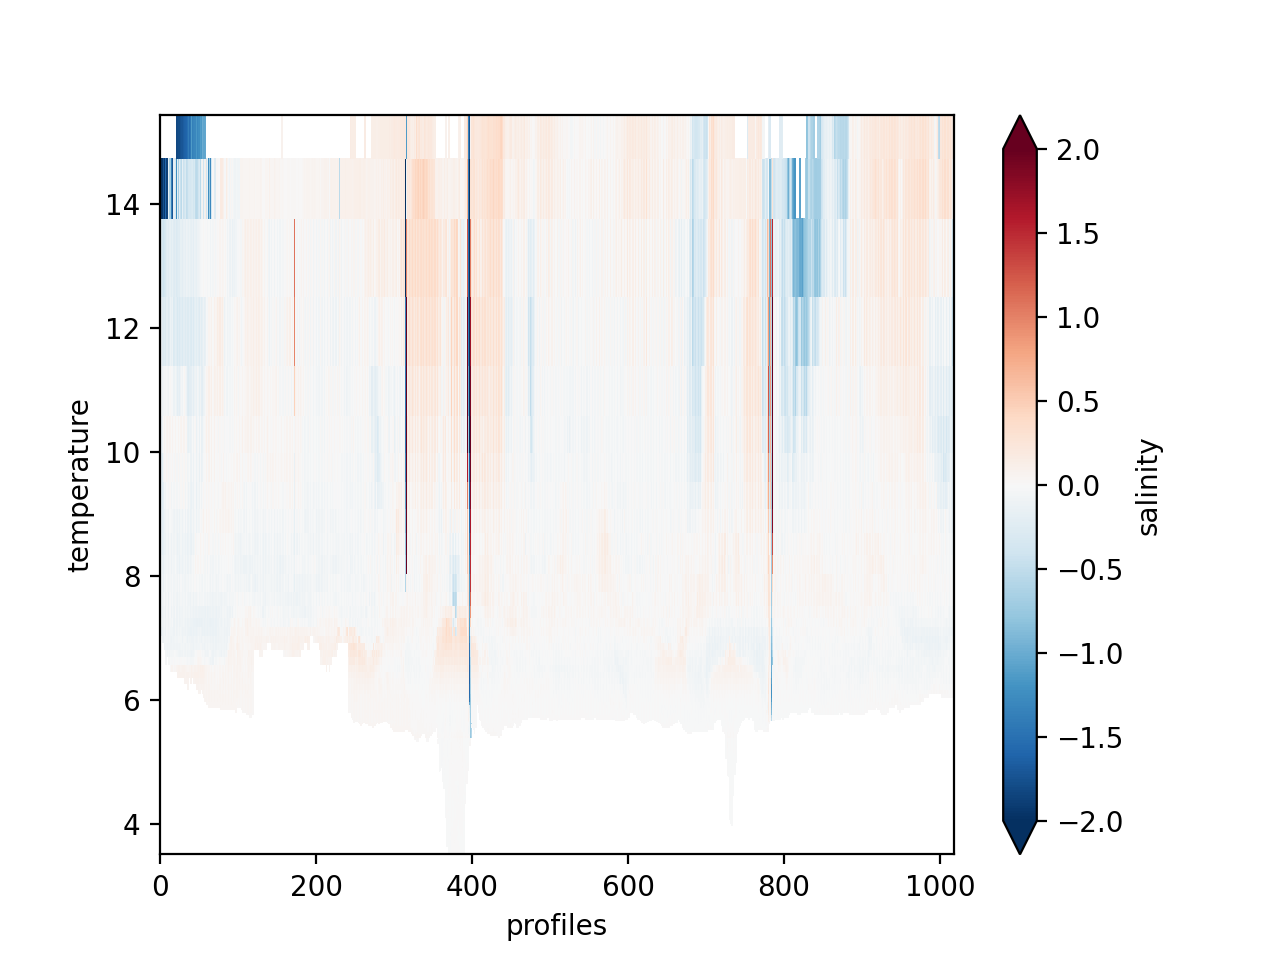

In [16]:
with xr.open_dataset('SalinityGrid.nc') as sal:
    fig, ax = plt.subplots()
    sal.salinity.plot(vmin=30)
    fig, ax = plt.subplots(2, 1)
    sal.salinity.std(dim='profiles').plot(ax=ax[0])
    sal.salinity.mean(dim='profiles').plot(ax=ax[1])
    fig, ax = plt.subplots()
    (sal['salinity']-sal.salinity.mean(dim='profiles')).plot(vmin=-2, vmax=2, cmap='RdBu_r')

In [14]:
!open bad_salinity.csv -a Atom

## T/C offset

Check if there should be a time offset applied to the conductivity cell to match the temperature.

From the plot below, we see that there is substantial asymmetry, with the profiles saltier on the way down (profile 220 and 222) than on the way up, particularly right near the seasonal thermocline.  



<IPython.core.display.Javascript object>


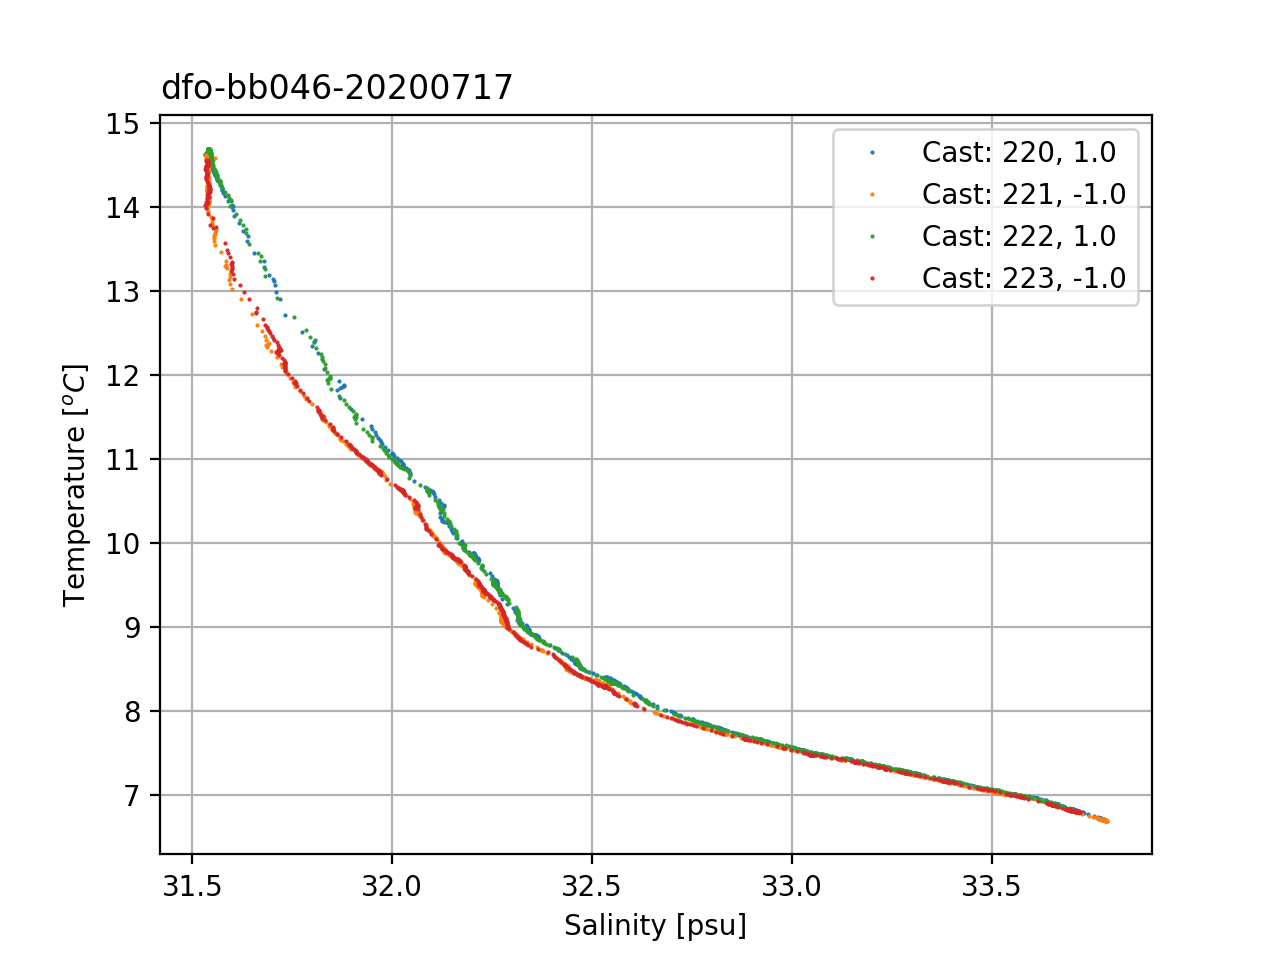

In [19]:

with get_timeseries() as ds0:
    fig, ax = plt.subplots()

    for td in range(220, 224):
        
        ds = ds0.where(ds0['profile_index']==td, drop=True)
        ax.plot(ds.salinity, ds.temperature, '.', markersize=1, label=f'Cast: {td}, {ds.profile_direction[10].values}' )
        ax.set_xlabel('Salinity [psu]')
        ax.set_ylabel('Temperature $[^oC]$')
        ax.set_title(f'{deploy_name}', loc='left')
        ax.grid(True)
    ax.legend()

This issue is easily seen in the temperature-gridded salinity shown above.

<xarray.Dataset>
Dimensions:            (profile_direction: 1019, profiles: 1018, temperature: 142)
Coordinates:
  * profiles           (profiles) float64 -0.0 1.0 2.0 ... 1.016e+03 1.017e+03
  * temperature        (temperature) float64 3.515 3.539 3.557 ... 14.37 15.08
  * profile_direction  (profile_direction) float64 0.0 -1.0 1.0 ... 1.0 -1.0 nan
Data variables:
    salinity           (temperature, profiles) float64 ...
    dS                 (temperature, profiles) float64 ...
    salinityClean      (temperature, profiles) float64 ...
    NgoodSal           (profiles) float64 ...
    NgoodSalClean      (profiles) float64 ...
    bad                (profiles) float64 ...


<IPython.core.display.Javascript object>


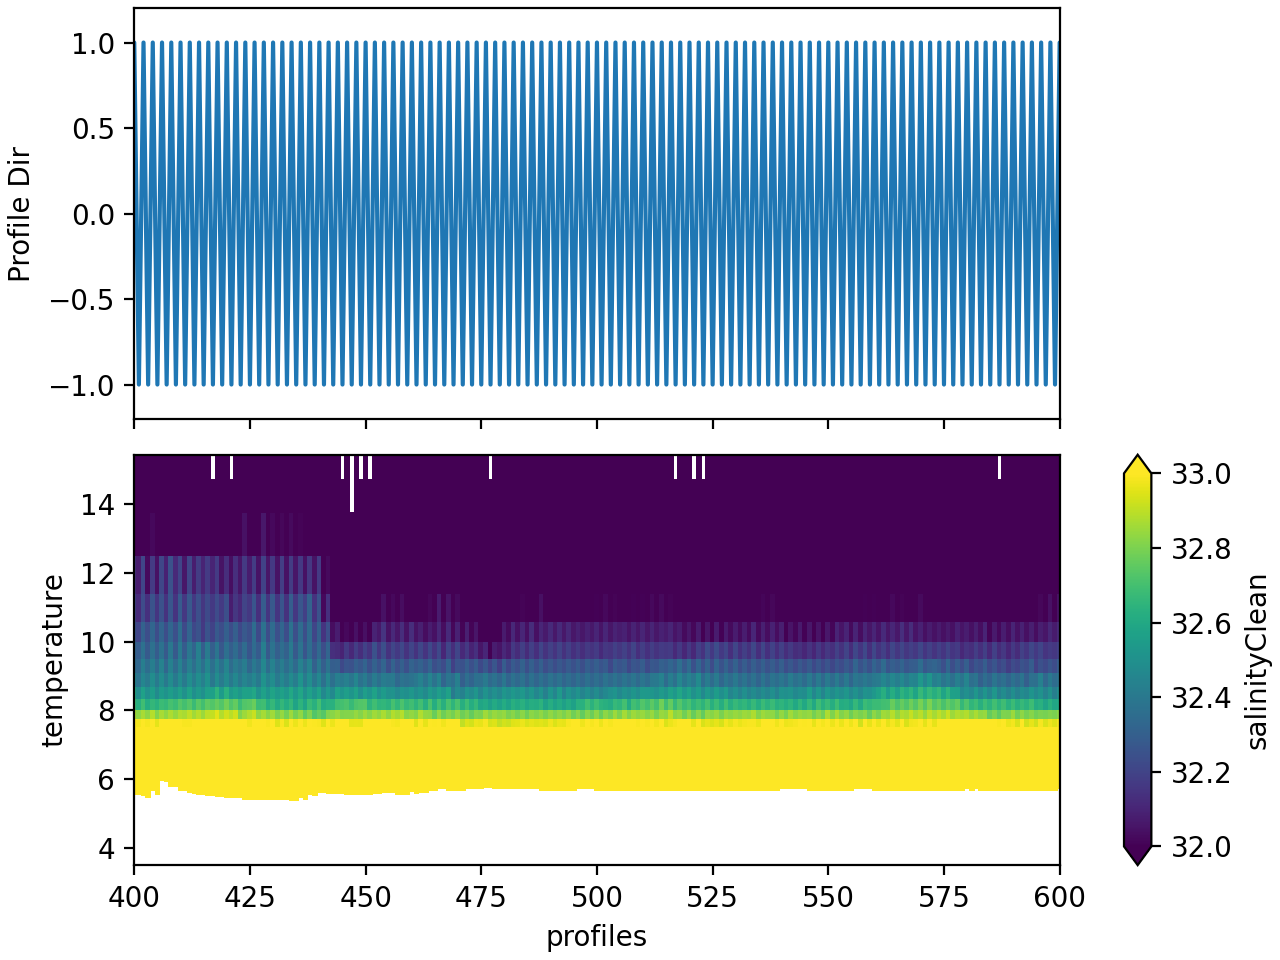

In [20]:
with xr.open_dataset('SalinityGrid.nc') as sal:
    print(sal)
    fig, ax = plt.subplots(2, 1, sharex=True, constrained_layout=True)
    ax[0].plot(sal.profiles, sal.profile_direction[:-1])
    ax[0].set_ylim([-1.2, 1.2])
    ax[0].set_ylabel('Profile Dir')
    sal.salinityClean.plot(ax=ax[1], vmin=32, vmax=33)
    ax[0].set_xlim(400, 600)

### Recursive filter on temperature

Following Garauetal11a, Morison et al 1994:

A correction to the temperature is made with the following filter: 

`dTn(n) = -b dTn(n-1) + a[T(n) - T(n-1)]`

or in terms of a `lfilter` with `a[0]=1`

`dTn(n) = a[1] * dTn[n-1] + b[0]*T[n] + b[1]*T[n-1]`

and `b[1] = -b[0]`.

They say $b_0 = \frac{4 f_n \alpha \tau}{1 + 4 f_n \tau}$, where $fn$ is the Nyquist frequency (=0.25 for seabird GPCTD), $\alpha$ is the amplitude of the error, and $\tau$ is a timeconstant.  $\alpha$ and $\tau$ are determined by minimizing the difference between up and down casts. 

```
 dtime = diff(time_val);
% sampling_freq = 1 ./ dtime;
% nyquist_freq = 0.5 * sampling_freq;
% coefa = alpha .* (4 * nyquist_freq .* tau) ./ (1 + 4 * nyquist_freq .* tau);
% coefb = 1 - 2  * (4 * nyquist_freq .* tau) ./ (1 + 4 * nyquist_freq .* tau);
% coefa = 2 * alpha ./ (2 + dtime .* beta); % from SBE Data Processing.
% coefb = 1 - 2 .* coefa ./ alpha;          
coefa = 2 * alpha ./ (2 + dtime ./ tau);  % same using tau instead of beta.
coefb = 1 - 4 ./ (2 + dtime ./ tau);
```


Below is an example of running this procedure on a snapshot of data, and the routine for doing the analysis.

<IPython.core.display.Javascript object>


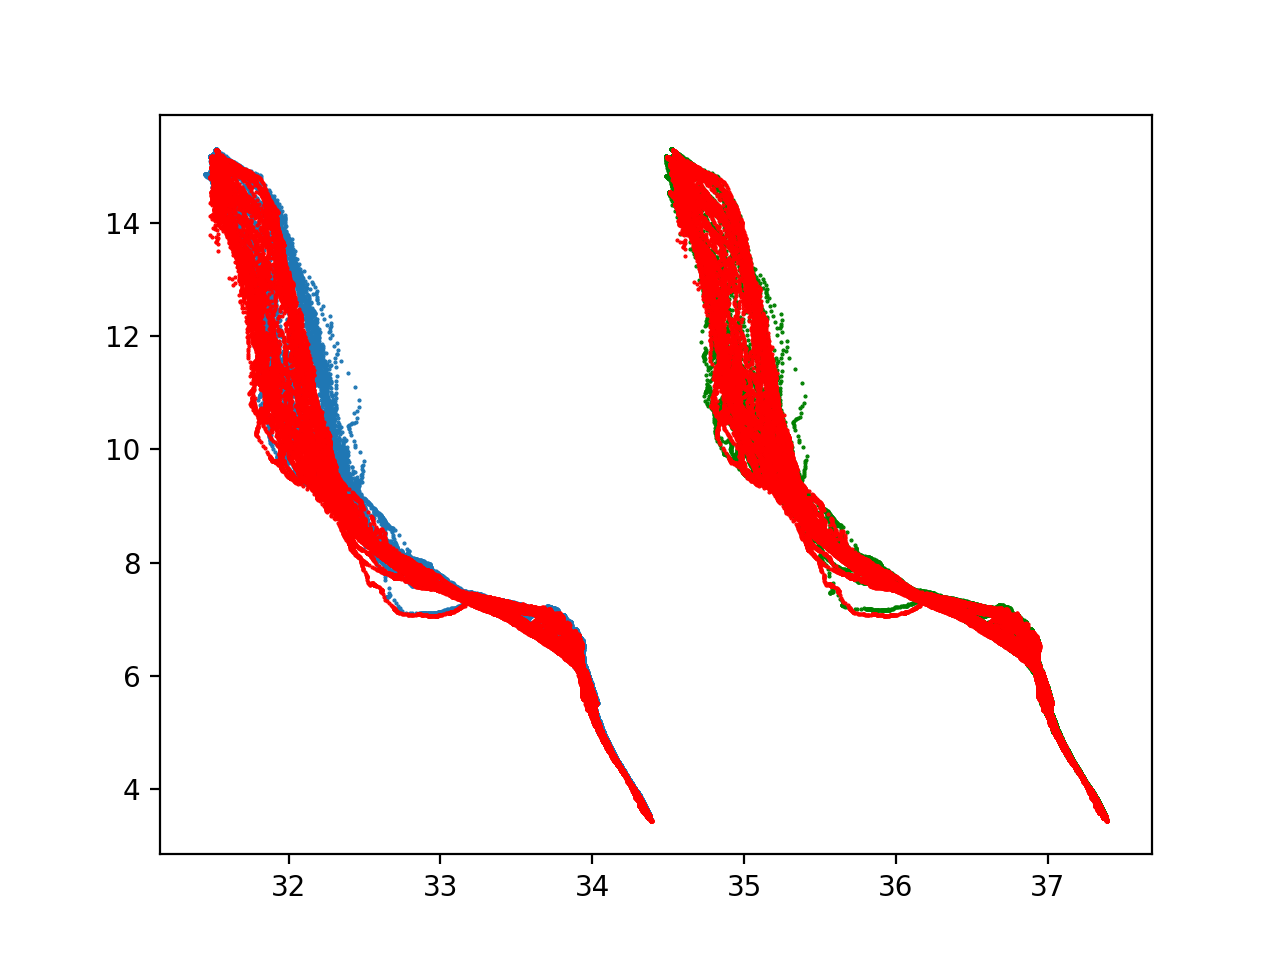

<IPython.core.display.Javascript object>


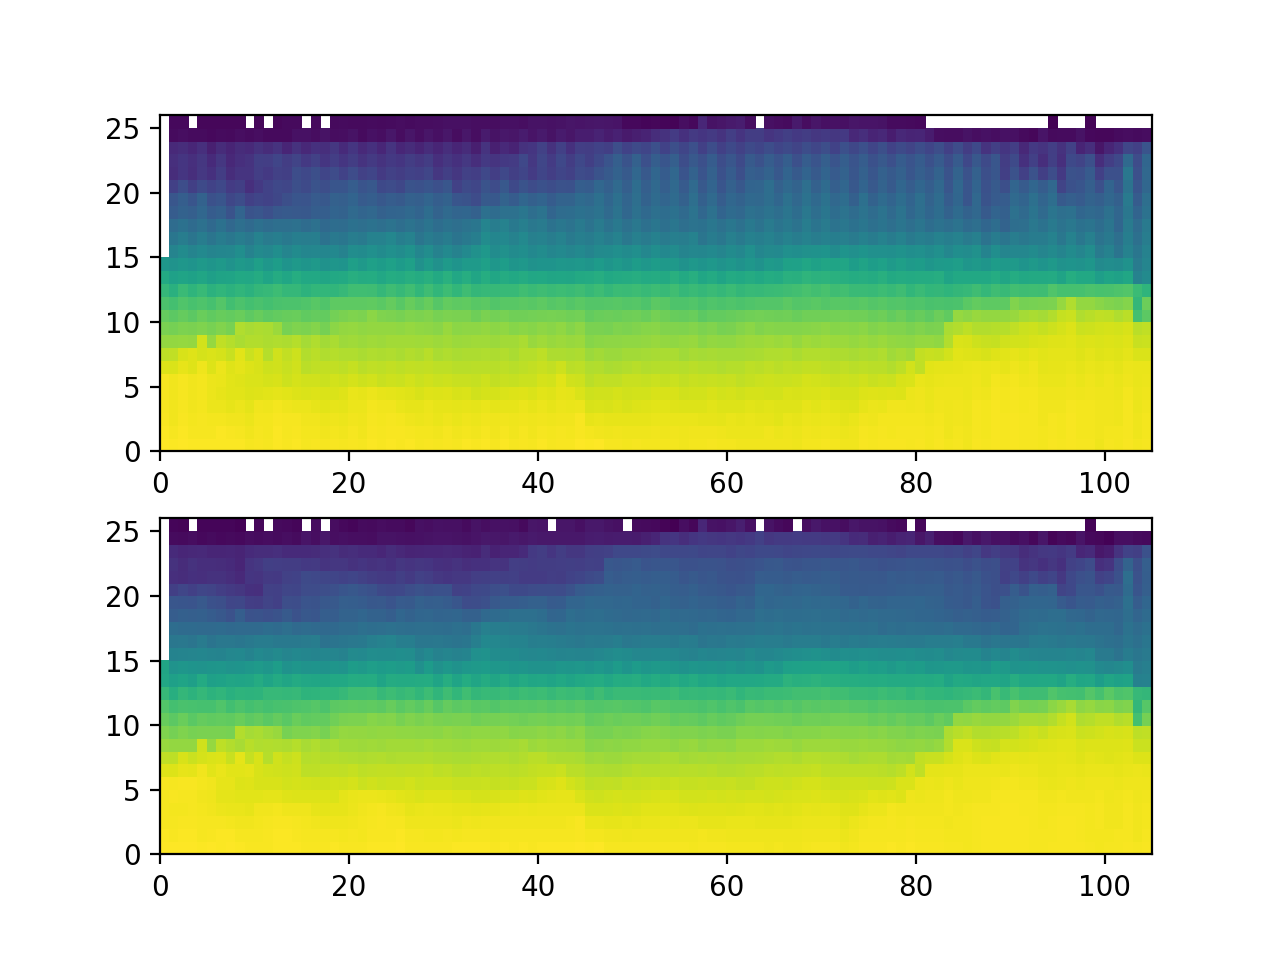

                        fun: 4.609543603275082
 lowest_optimization_result:       fun: 4.609543603275082
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.07687877, -0.05523333])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 6
      nit: 1
   status: 0
  success: True
        x: array([28.95309973, 30.17036422])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 2
                       nfev: 6003
                        nit: 100
                          x: array([28.95309973, 30.17036422])


In [40]:

def get_TS_diff(alphatau, ts, fn, reterr=True):

    alpha, tau = alphatau
    alpha = alpha / 1e3
    # print(alpha, tau)

    coefa = 4 * fn * alpha * tau / (1 + 4 * fn * tau)
    if coefa == 0:
        coefb = 0
    else:
        coefb = 1 - 2 * coefa / alpha
    b = np.array([1, -1]) * coefa
    a = np.array([1, coefb])


    ts = ts.where(np.isfinite(ts.temperature+ts.conductivity), drop=True)

    x0 = ts.temperature.values
    x0  = signal.lfilter(b, a, ts.temperature.values)
    
    ts['temperature'] =  ts.temperature - x0
    ts['salinity'].values = seawater.eos80.salt(ts.conductivity / seawater.constants.c3515 * 10, 
                                         ts.temperature, ts.pressure)
    ts = ts.where(np.isfinite(ts.salinity), drop=True)
    
    # bin the data:
    tbins = Tmean.values[::7]
    tbins = tbins[tbins<16]
    tbins = tbins[tbins > 6]
    profile_bins = np.unique(ts['profile_index'])
    direction = profile_bins * 0
    for n, i in enumerate(profile_bins):
        ind = np.where(ts['profile_index'] == i)[0]
        direction[n] = np.median(ts.profile_direction[ind])
    direction = direction[1:-1]
    profile_bins = profile_bins[1:]

    sal, xx, yy, binn = stats.binned_statistic_2d(
                        ts['temperature'].values,
                        ts['profile_index'].values,
                        values=ts['salinity'].values, statistic='mean',
                        bins=[tbins, profile_bins])
    ind = np.where(np.abs(np.diff(direction)))  
    err = np.nansum(np.nansum(np.diff(sal, axis=1)[:, ind]**2, axis=0))
    if reterr:
        return err
    else:
        return ts, sal


with get_timeseries() as ts:
    t0 = np.datetime64('2020-07-30', 'ns')
    ts = ts.isel(time=range(86400*4, 86400*7))
    ts = ts.where(np.isfinite(ts.temperature+ts.conductivity), drop=True, )
    for bad in bad_profiles:
        ts = ts.where(~(ts.profile_index==bad), drop=True)
    fig, ax = plt.subplots()
    ind = np.where(ts.profile_direction.values== 1)[0]
    ax.plot(ts.salinity[ind], ts.temperature[ind], '.', markersize=1)

    ind = np.where(ts.profile_direction.values == -1)[0]
    ax.plot(ts.salinity[ind], ts.temperature[ind], 'r.', markersize=1)

    import scipy.optimize as optimize

    bnds = ((0.0001, 200), (0.0001, 150))
    if 1:
        res = optimize.basinhopping(get_TS_diff, (20, 20), T=0.5, stepsize=2, 
                                    minimizer_kwargs={'tol':1e-4, 'bounds':bnds, 'args':(ts, 2)})
    
    tau = res.x[1]
    alpha = res.x[0] / 1e3
    
    newts, sal = get_TS_diff((alpha * 1e3, tau), ts, 2, reterr=False)
    
    ind = np.where(newts.profile_direction.values== 1)[0]
    ax.plot(newts.salinity[ind]+3, newts.temperature[ind], 'g.', markersize=1)

    ind = np.where(newts.profile_direction.values==-1)[0]
    ax.plot(newts.salinity[ind]+3, newts.temperature[ind], 'r.', markersize=1)

    fig, ax = plt.subplots(2, 1)
    ax[1].pcolormesh(sal)
    _, salold = get_TS_diff((0, 0), ts, 2, reterr=False)
    ax[0].pcolormesh(salold)

    print(res)

### Determine IIR filter co-eficitients

Using this minimizing procedure, we apply this in three day blocks.  The region of a "good" fit is quite broad, so here we choose $\tau = 20s$ and $\alpha = 0.02$

In [53]:
# WARNING: SLOW!!

import time, sys
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
with get_timeseries() as ts0:
    times = np.arange(ts0.time.values[0], ts0.time.values[-1], 7, dtype='datetime64[D]')
    ts0 = ts0.where(np.isfinite(ts0.temperature+ts0.conductivity), drop=True, )
    print('Dropped')
    for bad in bad_profiles:
        ts0 = ts0.where(~(ts0.profile_index==bad))
    print('Bad dropped')
    alphas = np.zeros(len(times)) + np.NaN
    taus = np.zeros(len(times)) + np.NaN
    
    at0 = (2, 20)
    for nn, t0 in enumerate(times):
        ts = ts0.sel(time=slice(t0, t0 + np.timedelta64(3, 'D')))
        bnds = ((0.0001, 200), (0.0001, 150))
        res = optimize.basinhopping(get_TS_diff, at0, niter=20, 
                                    minimizer_kwargs={'tol':1e-4, 'args': (ts, 2), 'bounds':bnds})
        print(res)
        if res.lowest_optimization_result.success:
            alphas[nn] = res.x[0] / 1e3
            taus[nn] = res.x[1]
            at0 = (np.nanmean(alphas) * 100, np.nanmean(taus))
        update_progress(nn / len(times))


Progress: [#############-------] 66.7%


27413.71473134984


<IPython.core.display.Javascript object>


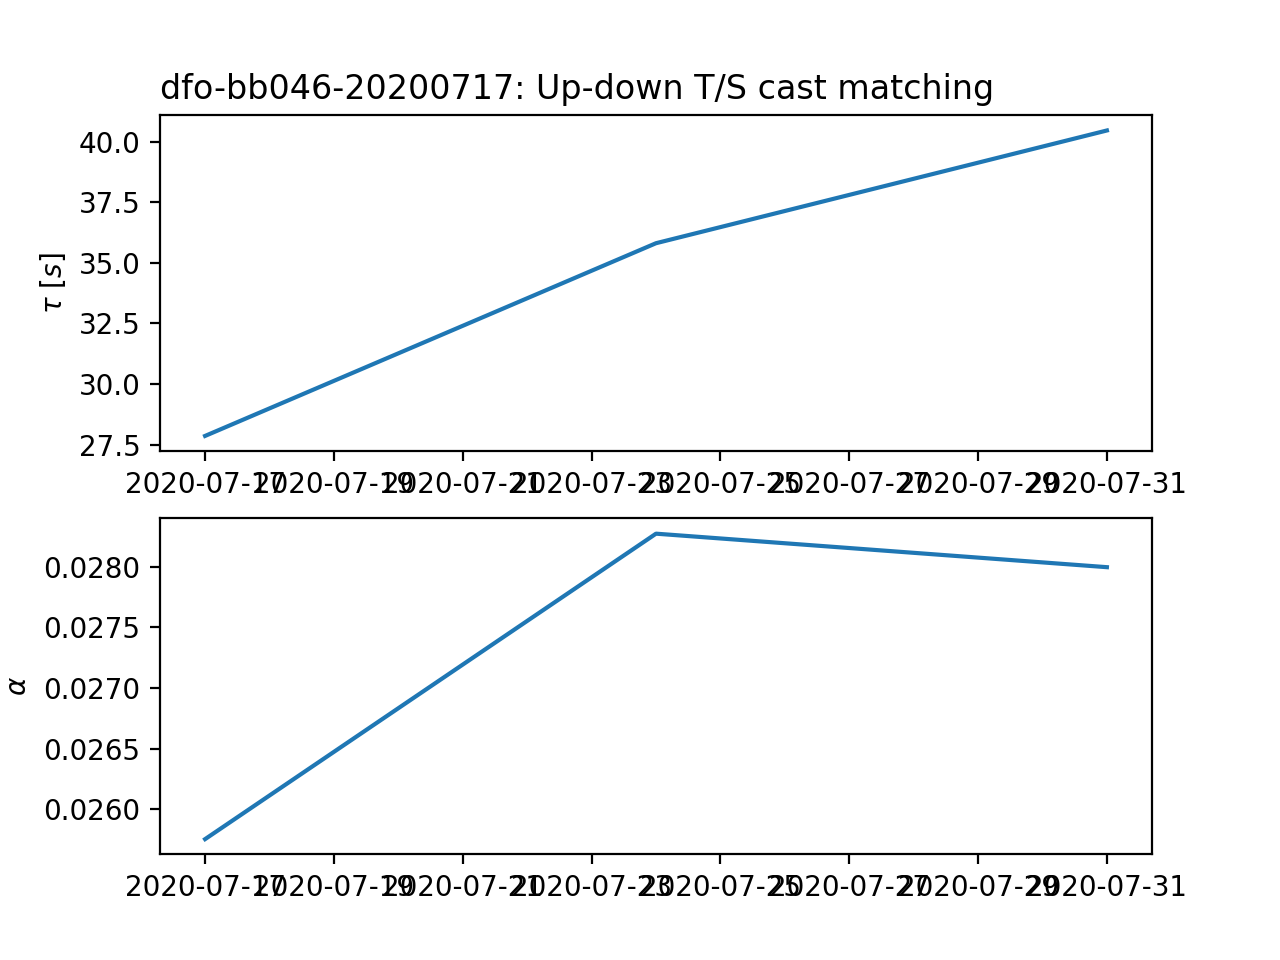

Text(0, 0.5, '$\\alpha$')

In [54]:
fig, axs = plt.subplots(2,1)
axs[0].plot(times, taus)
axs[0].set_ylabel(r'$\tau\ [s]$')
axs[0].set_title(f'{deploy_name}: Up-down T/S cast matching', loc='left')
axs[1].plot(times, alphas)
axs[1].set_ylabel(r'$\alpha$')

### Apply correction

In [93]:
def correct_salinity(ts, tau=12, alpha=0.03, fn=0.25):
    """
    Apply the Lueck 1990, Morrison et al 1994 salinity correction to the the data.
    
    Parameters:
    -----------
    
    ts : xarray
        timeseries data, must have 'temperature', 'salinity', 'conductivity', and 
        'pressure' variables.
    
    tau : float
        time constant, seconds for filter to apply to temperature data used to 
        calculate the salinity
        
    alpha : float
        fraction of the signal to correct.

    Note that ``tau`` and ``alpha`` are determined empirically 
    (i.e. see write up in ``process_delayed_20190718``).
    """
    
    coefa = 4 * fn * alpha * tau / (1 + 4 * fn * tau)
    if coefa == 0:
        coefb = 0
    else:
        coefb = 1 - 2 * coefa / alpha
    b = np.array([1, -1]) * coefa
    a = np.array([1, coefb])

    good = np.where(np.isfinite(ts.temperature))
    print('done good')
    x0 = ts.temperature.values[good]
    x0  = signal.lfilter(b, a, x0)
    print('Done filter')
    t =  ts.temperature.values[good] - x0
    ts['salinity'].values[good] = seawater.eos80.salt(ts.conductivity.values[good] / seawater.constants.c3515 * 10, 
                                         t, ts.pressure.values[good])
    ts['salinity'].attrs['comment'] = ('Salinity, calculated from temperature filtered to minimize '
                                      'up/down profile differences, following Morison et al 1994. '
                                      'Constants calculated from cruise means and checked in notebook.')
    ts['salinity'].attrs['temp_corrections_factors'] = f'alpha={alpha}, tau={tau}'
    ts['salinity'].attrs['method'] += ' ncprocess.correct_salinity'
    
    ts.potential_density.values = seawater.eos80.pden(ts.salinity, ts.potential_temperature, ts.pressure, 0)
    
    ts.attrs['data_mode'] = 'M'
    ts.attrs['processing_level'] = 'Mixed: salinity thermal lag corrections applied'
    
    return ts

import os
try:
    os.mkdir(f'{deploy_prefix}/L1-timeseries/')
except:
    pass
    
with get_timeseries() as ts:
    ts = correct_salinity(ts, tau=25, alpha = 0.02, fn=2)
    # !mkdir /Users/jklymak/gliderdata/deployments/dfo-walle652/dfo-walle652-20190718/L1-timeseries/
    ts.to_netcdf(f'{deploy_prefix}/L1-timeseries/{deploy_name}_L1.nc')
    print(f'Saved {deploy_prefix}/L1-timeseries/{deploy_name}_L1.nc')

done good
Done filter
Saved /Users/jklymak/gliderdata/deployments/dfo-bb046/dfo-bb046-20200717//L1-timeseries/dfo-bb046-20200717_L1.nc


### make grid

Making the level-1 grid with the new salinity in it, and plotting.  There is still *some* residual up-down assymetry, but it is substantially less than before, and this is really a very strong thermocline right here.  

In [94]:
ncprocess.make_L2_gridfiles(f'{deploy_prefix}/L1-timeseries/{deploy_name}_L1.nc', 
                            f'{deploy_prefix}/L1-gridfiles/', './deployment.yml')

Working on:
<xarray.Dataset>
Dimensions:                (time: 1747149)
Coordinates:
  * time                   (time) float64 1.595e+09 1.595e+09 ... 1.597e+09
    latitude               (time) float64 ...
    longitude              (time) float64 ...
    depth                  (time) float64 ...
Data variables:
    heading                (time) float64 ...
    pitch                  (time) float64 ...
    roll                   (time) float64 ...
    conductivity           (time) float64 ...
    temperature            (time) float64 ...
    pressure               (time) float64 ...
    chlorophyll            (time) float64 ...
    cdom                   (time) float64 ...
    backscatter_700        (time) float64 ...
    oxygen_concentration   (time) float64 ...
    temperature_oxygen     (time) float64 ...
    distance_over_ground   (time) float64 ...
    profile_index          (time) float64 ...
    profile_direction      (time) float64 ...
    salinity               (time) float64

'/Users/jklymak/gliderdata/deployments/dfo-bb046/dfo-bb046-20200717//L1-gridfiles//dfo-bb046-20200717_grid.nc'

<IPython.core.display.Javascript object>


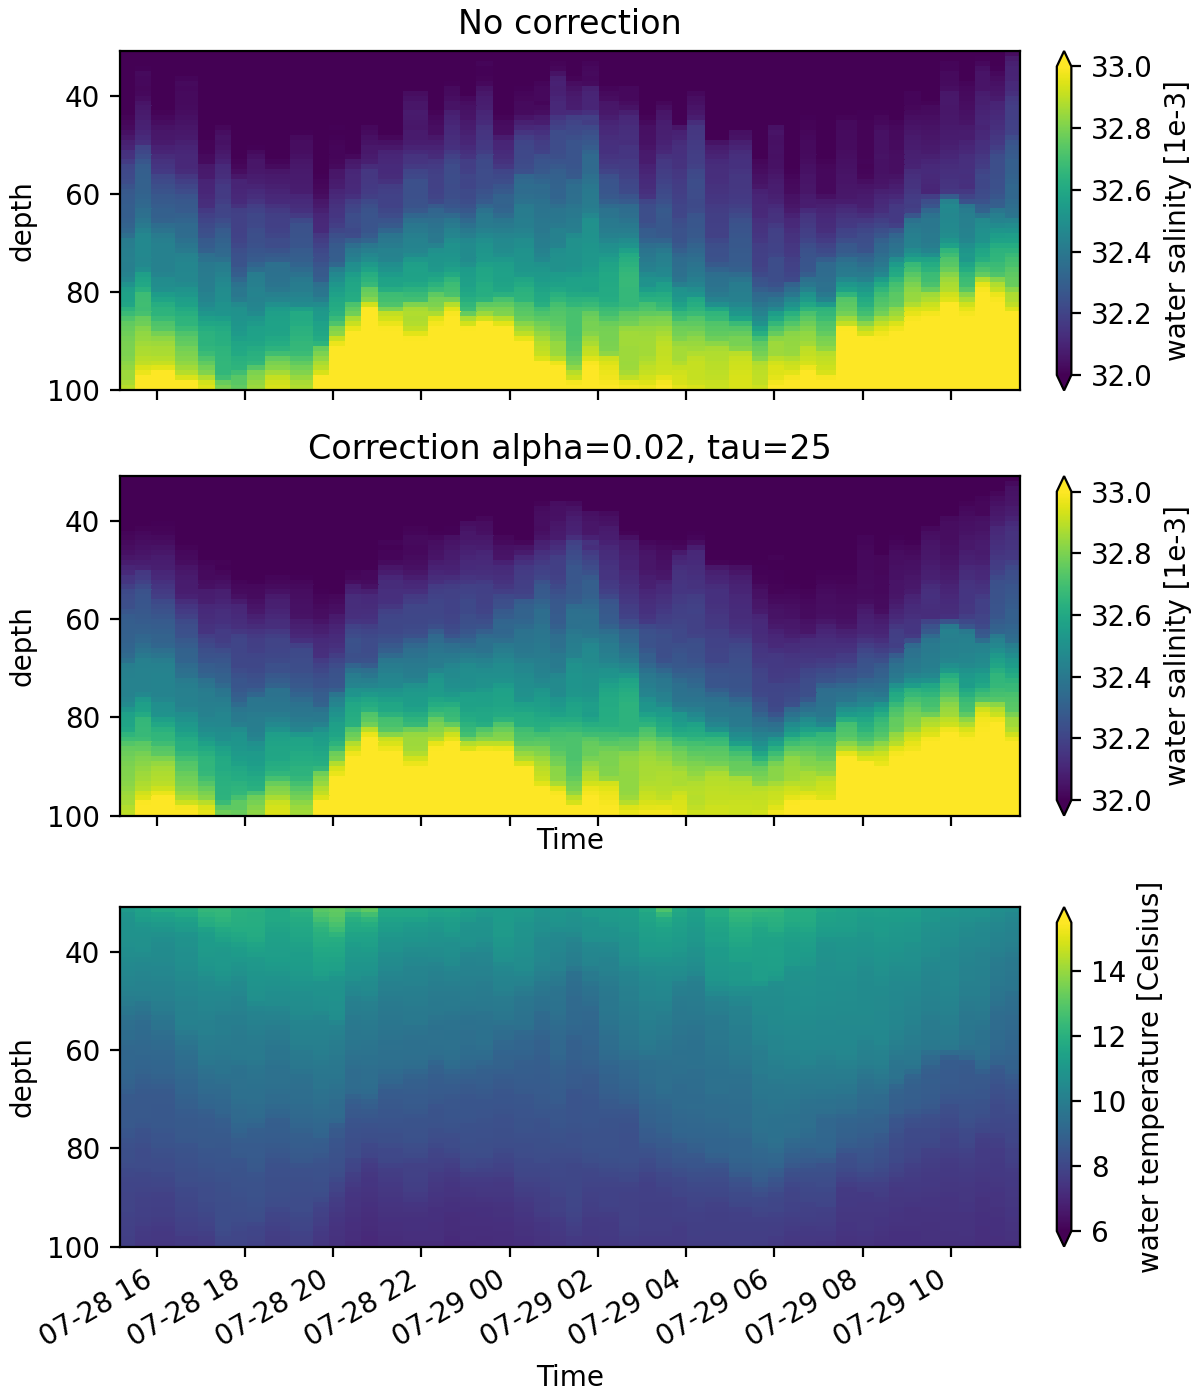

<IPython.core.display.Javascript object>


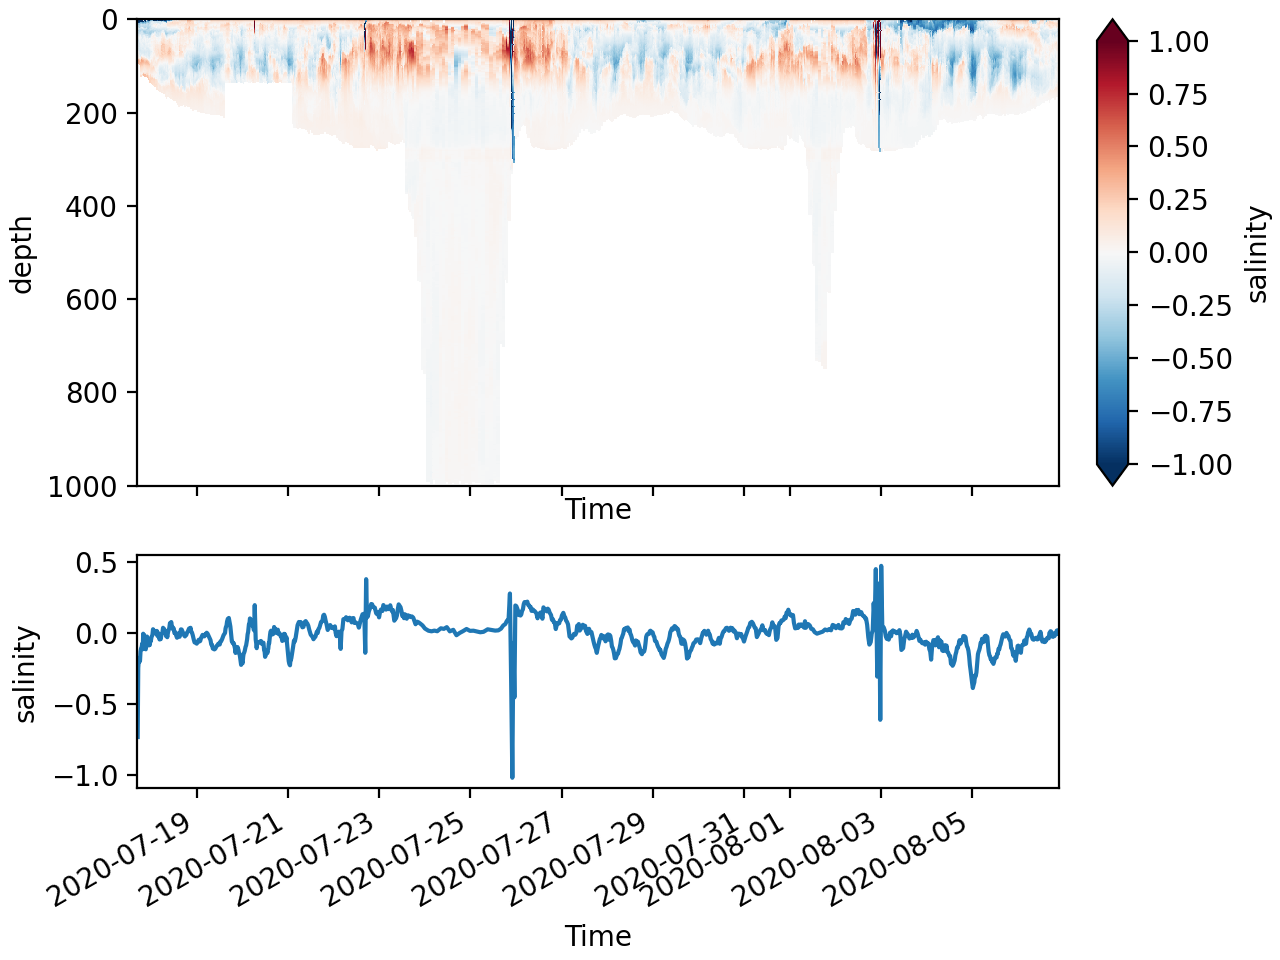

In [95]:
with get_gridfile(level='L1') as ds:
    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, constrained_layout=True, figsize=(6, 7))
    ds.salinity.plot(ax=axs[1], vmin=32, vmax=33)
    axs[1].set_title('Correction ' + ds.salinity.attrs['temp_corrections_factors'])

    with get_gridfile(level='L0') as ds:
        ds.salinity.plot(ax=axs[0], vmin=32, vmax=33)
        axs[0].set_title('No correction')
    axs[0].set_xlabel('')
    
    ds.temperature.plot(ax=axs[2], vmin=6, vmax=15.5)
    
    #axs[0].set_xlim(np.datetime64('2019-10-03'), np.datetime64('2019-10-09'))
    axs[0].set_ylim(100, 0)
# ## Screen for outliers (T and S)
#
# This is really much more easily done on the gridded data, but should feed back to the time series data as well.  As seen above in the first-pass at this, there isn't that much data that is bad, and can almost be edited by hand.  Its tempting to also just remove whole profile, which is a pretty easy thing to do.  Are there many profiles where the salps didn't mess up most of the profile?
#

with get_gridfile(level='L1') as ds:
    t = ds.salinity - ds.salinity.mean(dim='time')
    fig, axs = plt.subplots(2, 1, constrained_layout=True, sharex=True, gridspec_kw={'height_ratios':[1 , 0.5]})
    t.plot(ax=axs[0], vmin=-1, vmax=1, cmap='RdBu_r')
    axs[0].set_ylim(1000, 0)
    t.mean(dim='depth').plot(ax=axs[1])

## Screening bad data

This is probably not much different than above, but it would be nice to automate it somewhat.  What makes a bad temperature or salinity?  Very much out of the natural range.  It is also nice to feed this back into the time series, so that will be a bit of an issue, but starting on density will be quickest...

  - Remove outliers
  - Screen bad T/S
  - Find salinity anomalies

### Grid onto potential density

<xarray.DataArray 'potential_density' ()>
array(1027.36419746)
<xarray.DataArray 'potential_density' ()>
array(1021.13160719)


<IPython.core.display.Javascript object>


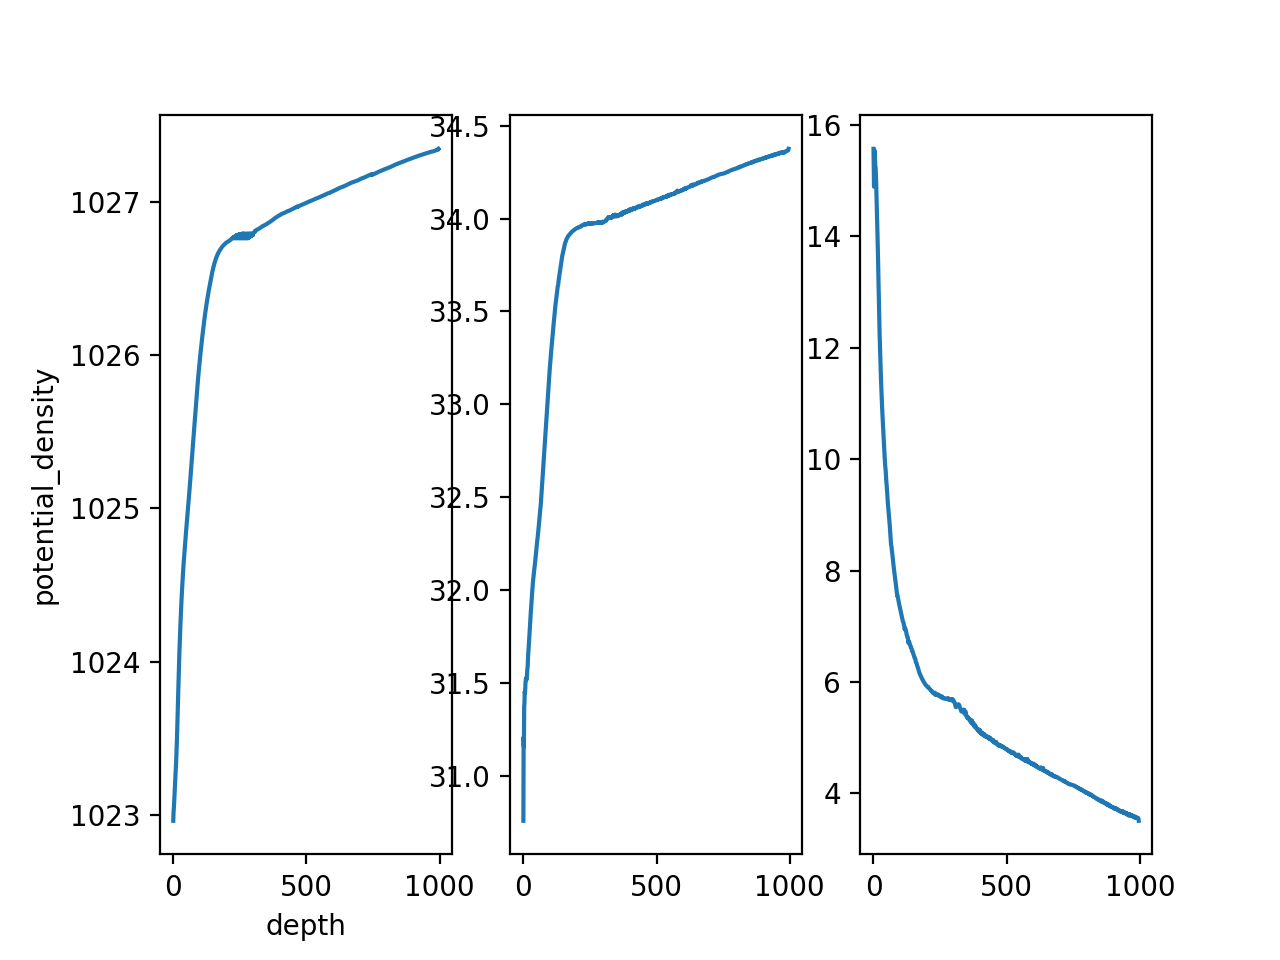

In [76]:
with get_gridfile() as ds:
    Rmean = ds['potential_density'].mean(dim='time')
    print(ds.potential_density.max())
    print(ds.potential_density.min())
    
means = xr.Dataset()
Rmean = Rmean.sortby(Rmean, ascending=True).where(np.isfinite(Rmean), drop=True)

Rbins = Rmean[::1]
Rbins = np.hstack([1020, Rbins, 1027.4])
# print(Rbins, type(Rbins))

with get_timeseries(level='L1') as ts:
    good = np.where(np.isfinite(ts.salinity + ts.potential_density + ts.temperature))[0]
    Smean, _, _ = stats.binned_statistic(ts.potential_density.values[good], 
                                         ts.salinity.values[good], statistic='mean', bins=Rbins)

    Tmean, _, _ = stats.binned_statistic(ts.potential_density.values[good], ts.temperature.values[good], 
                                         statistic='mean', bins=Rbins)
    


fig, ax = plt.subplots(1, 3)
Rmean.plot(ax=ax[0])

ax[1].plot(Smean)

ax[2].plot(Tmean)


### Make salinity anomaly along isopycnals

We will compute this as $\delta S(\sigma_{\theta}) = S(\sigma_{\theta}) - S_0 (\sigma_{\theta})$.  We will then high-pass this to remove regional differences

In [77]:
!atom ./bad_salinity.csv

<IPython.core.display.Javascript object>


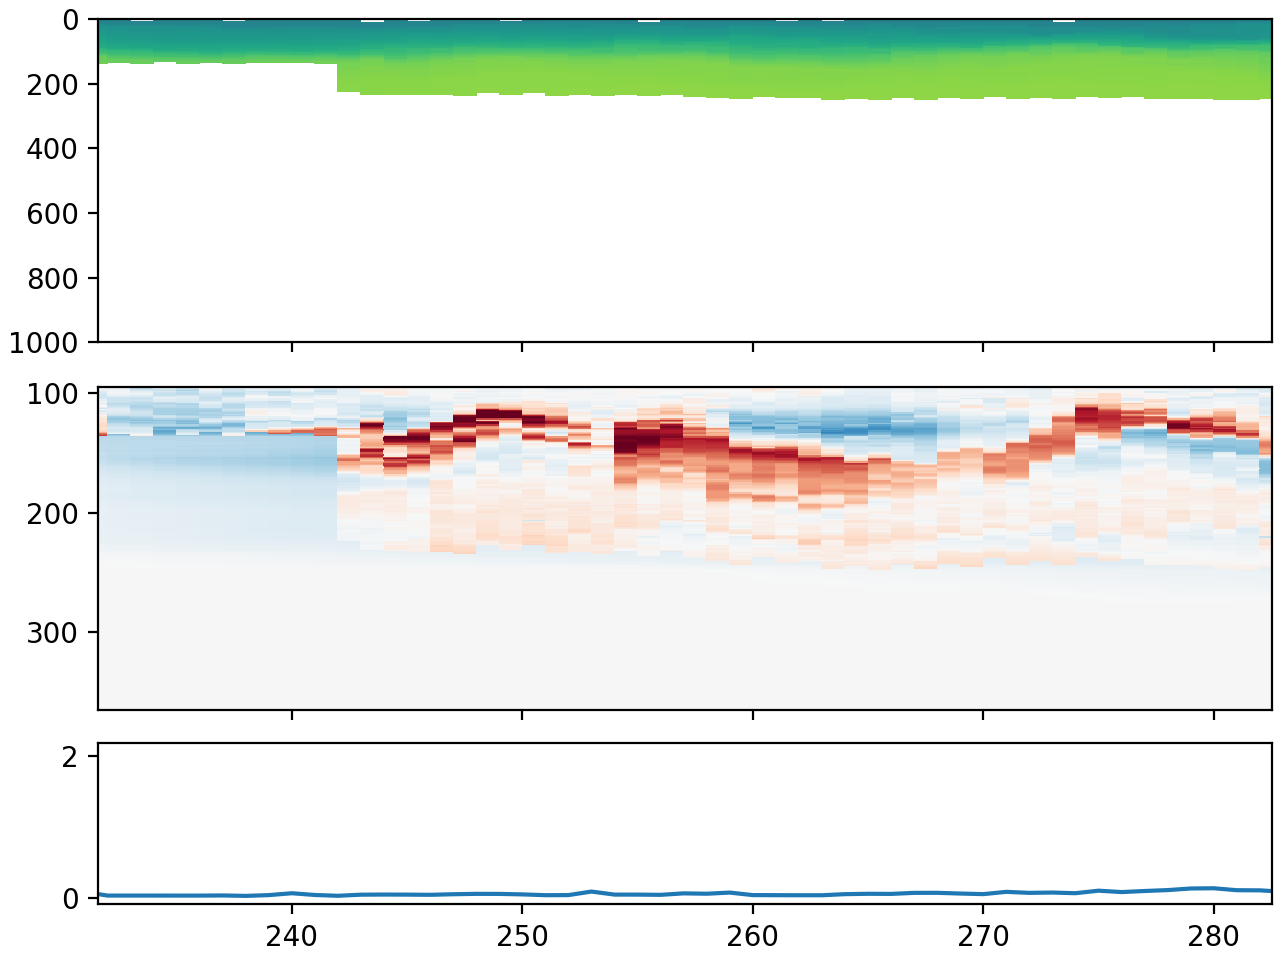

In [97]:
with get_gridfile(level='L1') as ds:
    sanom = ds.salinity - np.interp(ds.potential_density, Rbins[:-1] + np.diff(Rbins) / 2, Smean)
    sanom = sanom.fillna(0)
    s0 = sanom.rolling(time=61, center=True).mean()
    ds['salinity_anomaly'] = sanom - s0
    fig, ax = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios':[1, 1, 0.5]}, constrained_layout=True)
    ax[0].pcolormesh(ds.profile, ds.depth,ds.salinity)
    ax[0].set_ylim(1000, 0)

    ax[1].pcolormesh(ds.profile, ds.depth, ds.salinity_anomaly, vmin=-0.05, vmax=0.05, cmap='RdBu_r')
    ax[1].set_ylim(1000, 0)
    
    ax[2].plot(ds.profile, np.nanmax(np.abs(ds.salinity_anomaly.values), axis=0))

We use the plot above to make `bad_salinity.csv` and then that is readily read in with pandas

<IPython.core.display.Javascript object>


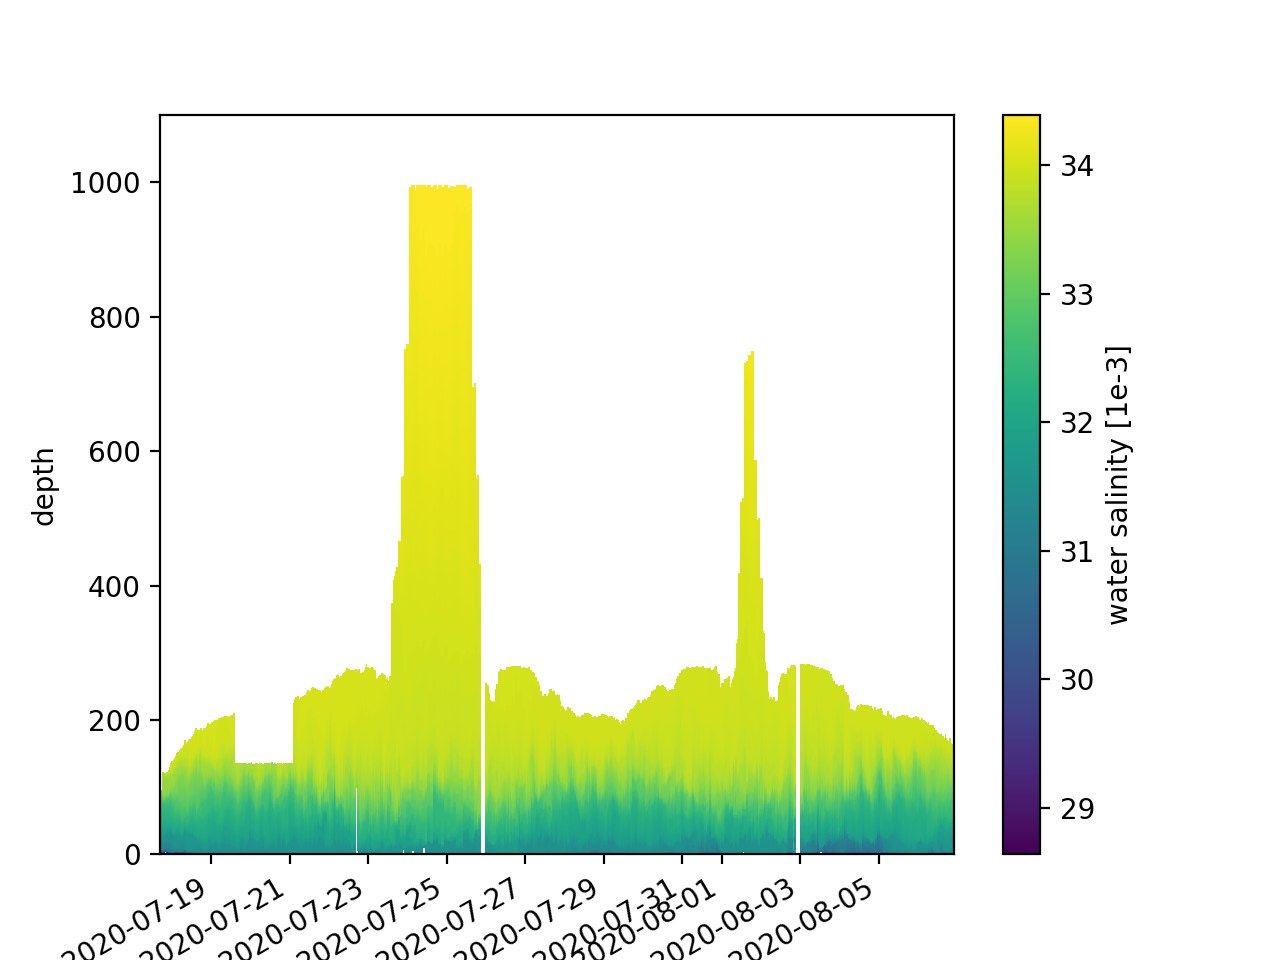

In [98]:
import os 
import datetime
try:
    os.mkdir(f'{deploy_prefix}/L2-gridfiles/')
except:
    pass
import pandas as pd 

bad_salinity =  pd.read_csv('bad_salinity.csv')
with get_gridfile(level='L1') as ds:
    for index, bad in bad_salinity.iterrows():   
        ind = np.where(ds.profile == bad.profile)[0]
        badd = np.where((ds.depth > bad.pstart) & (ds.depth<bad.pstop))[0]
        ds.salinity[badd, ind] = np.NaN
        ds.potential_temperature[badd, ind] = np.NaN
        ds.potential_density[badd, ind] = np.NaN

        
    fig, ax = plt.subplots()
    ds.salinity.plot()
    ds.salinity.attrs['comment'] += ';\nSalinity spikes removed manually (bad_salinity.csv);'
    ds.attrs['date_modified'] = datetime.datetime.now().isoformat()
    ds.attrs['processing_level'] += ';\nSalinity spikes removed (conductivity not changed); '
    
    ds.to_netcdf(f'{deploy_prefix}/L2-gridfiles/{deploy_name}_grid.nc')

### Make L2 time series

In [99]:
os.system(f'mkdir {deploy_prefix}/L2-timeseries/')


with get_gridfile(level='L1') as ts:
    for index, bad in bad_salinity.iterrows():   
        ind = np.where((ts.profile_index == bad.profile) &
                       (ts.pressure > bad.pstart) &
                       (ts.pressure < bad.pstop))[0]
        ts.salinity[ind] = np.NaN
        ts.potential_density[ind] = np.NaN
        ts.potential_temperature[ind] = np.NaN

        
    ts.salinity.attrs['comment'] += ';\nSalinity spikes removed manually (bad_salinity.csv);'
    ts.attrs['date_modified'] = datetime.datetime.now().isoformat()
    ts.attrs['processing_level'] += ';\nSalinity spikes removed (conductivity not changed); '
    
    ts.to_netcdf(f'{deploy_prefix}/L2-timeseries/{deploy_name}_L2.nc')


In [90]:
ts.attrs

{'Conventions': 'CF-1.6',
 'Metadata_Conventions': 'CF-1.6, Unidata Dataset Discovery v1.0',
 'acknowledgement': 'Funding from Fisheries and Oceans Canada, Canadian Foundation for Innovation, BC Knowledge Development Fund',
 'cdm_data_type': 'Trajectory',
 'comment': 'Calvert Island deployment',
 'contributor_name': 'James Pegg, Jody Klymak, Tetjana Ross',
 'contributor_role': 'Lead Technician, Principal Investigator, Co-PI',
 'creator_email': 'jklymak@uvic.ca',
 'creator_name': 'Jody Klymak',
 'creator_url': 'http://cproof.uvic.ca',
 'date_created': '2020-08-08T20:19:30Z',
 'date_issued': '2020-08-08T20:19:30Z',
 'date_modified': '2020-08-09T10:36:39.565740',
 'deployment_end': '2020-08-06T23:30:19',
 'deployment_id': '1',
 'deployment_name': 'dfo-bb046-20200717',
 'deployment_start': '2020-07-17T16:28:43',
 'featureType': 'timeseries',
 'format_version': 'IOOS_Glider_NetCDF_v2.0.nc',
 'geospatial_lat_max': 51.69618333333333,
 'geospatial_lat_min': 50.9822,
 'geospatial_lat_units': 'd

<xarray.DataArray 'time' (time: 1747148)>
array([ 986999808,  999000064, 1008000000, ...,  996999936, 1008999936,
        998000128], dtype='timedelta64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2020-07-17T16:28:44.712999936 ... 2020-08-06T23:30:19.072000
    latitude   (time) float64 ...
    longitude  (time) float64 ...
    depth      (time) float64 ...


<IPython.core.display.Javascript object>


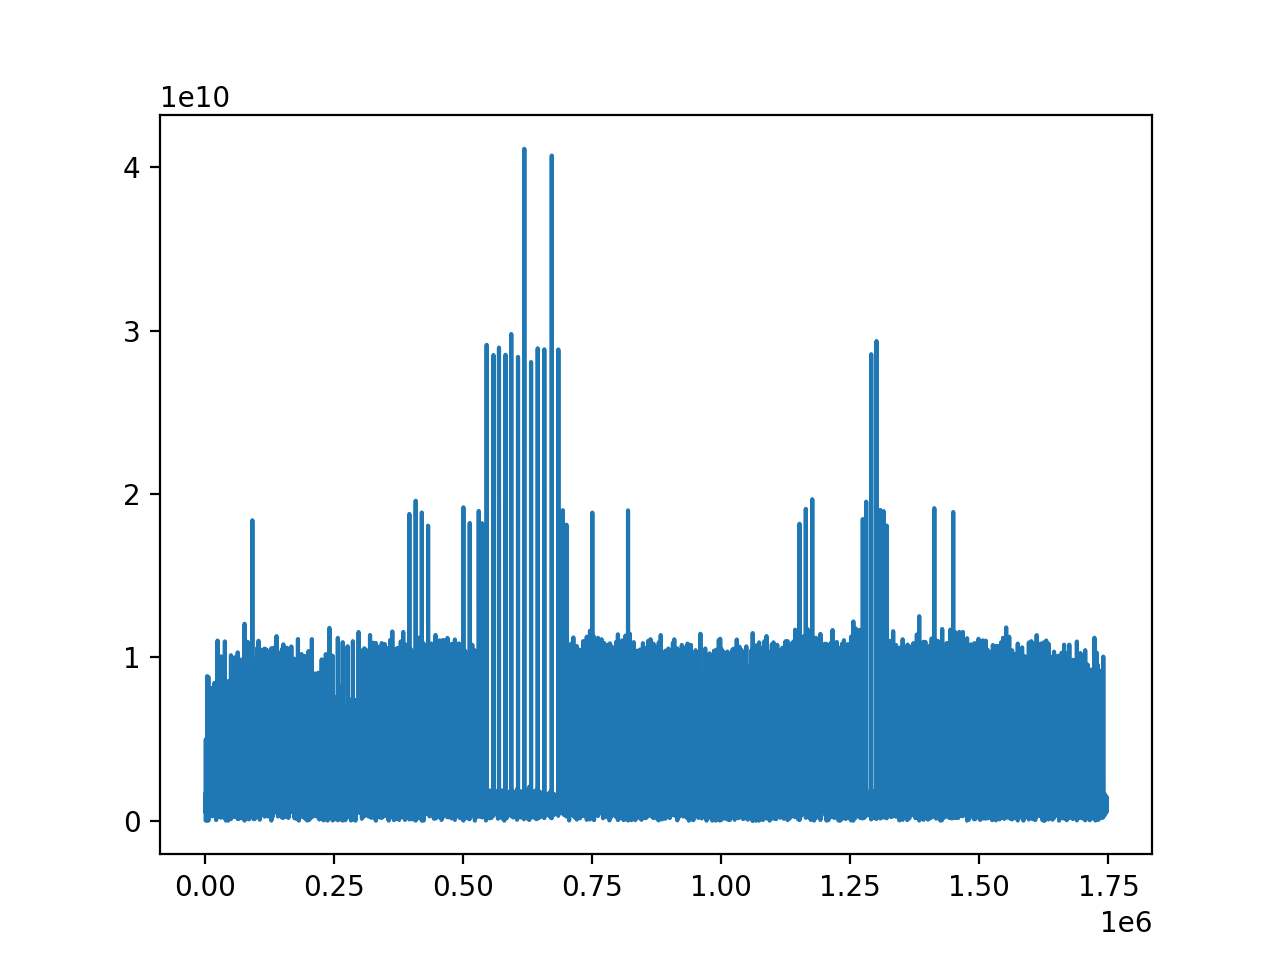

In [91]:
with get_timeseries() as ts0:
    print(ts0.time.diff('time'))
    fig, ax = plt.subplots()
    ax.plot(ts0.time.diff('time'))